In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import math
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
if torch.cuda.is_available():
    print("Yeah we have a GPU!")
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

import pandas as pd
import plotly.express as px

from gdeep.decision_boundary.decision_boundary_calculator import *
from gdeep.create_nets.sample_nn import Net, CircleNN
from gdeep.create_nets.utility import ToFastaiNN, ToPyTorchNN, PeriodicNeuralNetworkMaker
from gdeep.plotting.plot_decision_bdry import plot_activation_contours
from gdeep.create_data.tori import make_torus_point_cloud, Rotation, make_torus_dataset
from gdeep.create_nets.utility import train_classification_nn
from gdeep.decision_boundary.compute_boundary import GradientFlow, UniformlySampledPoint
from gdeep.plotting import plot_decision_boundary

In [6]:
g = GradientFlowDecisionBoundaryCalculator(
            model=CircleNN(),
            initial_points=torch.distributions.uniform.Uniform(-10.,10.).sample((100, 2)),
            optimizer=lambda params: torch.optim.Adam(params)
)

In [7]:
circle_detect_nn = CircleNN()


plot_activation_contours(ToFastaiNN(circle_detect_nn), boundary_tuple=((-10,10),(-10,10)))


In [8]:
periodic_circle_nn = PeriodicNeuralNetworkMaker(circle_detect_nn, [(0,0.5),(-0.5,0.5)])


plot_activation_contours(ToFastaiNN(periodic_circle_nn), boundary_tuple=((-10,10),(-10,10)))

In [9]:
# Generate Dataset
tori_dataset = make_torus_dataset()

# Define neural network architecture
tori_detector = Net(0, [3,20,20,20,20])

# Train neural network
tori_detector = train_classification_nn(tori_detector, tori_dataset[["x1","x2","x3"]].to_numpy(),
                                        tori_dataset["label"].to_numpy(), n_epochs=10).model

epoch,train_loss,valid_loss,accuracy,time
0,0.858867,0.742423,0.524000,00:00
1,0.473777,0.363964,0.965000,00:00
2,0.338922,0.320071,1.000000,00:00
3,0.317865,0.315043,1.000000,00:00
4,0.314565,0.314054,1.000000,00:00
5,0.313826,0.313688,1.000000,00:01
6,0.313566,0.313519,1.000000,00:00
7,0.313453,0.313443,1.000000,00:00
8,0.313408,0.313417,1.000000,00:01
9,0.313394,0.313406,1.000000,00:01


In [10]:
tori_detector_pytorch = ToPyTorchNN(tori_detector).to(dev)
for param in tori_detector_pytorch.parameters():
            param.requires_grad = False

n_samples = 100

point_sample_generator = UniformlySampledPoint([(-2,4),(-2,2),(-2,2),(0,2*np.pi),(-1.,1.)], n_samples=n_samples)
point_sample_tensor = torch.from_numpy(point_sample_generator()).float()

phi = point_sample_tensor[:,-2].reshape(-1,1)
theta = point_sample_tensor[:,-1].reshape(-1,1)
theta = torch.acos(theta)

y0 = torch.cat((torch.sin(theta) * torch.cos(phi),\
                torch.sin(theta) * torch.sin(phi),\
                torch.cos(theta)), -1)

g = QuasihyperbolicDecisionBoundaryCalculator(
            model=tori_detector_pytorch,
            initial_points=point_sample_tensor[:,:3].to(dev),#torch.ones_like(y0).to(dev),#torch.distributions.uniform.Uniform(-10.,10.).sample((n_samples, 3)).to(dev),
            initial_vectors=y0.to(dev),
            integrator=None #lambda params: torch.optim.Adam(params, )
)
g.step(100)

In [11]:
sample_points_boundary = g.get_filtered_decision_boundary(0.01).detach().cpu().numpy()
#sample_points_boundary = g.get_decision_boundary().detach().cpu().numpy()

fig = plot_decision_boundary(tori_dataset[["x1","x2","x3"]].to_numpy(), tori_dataset["label"].to_numpy(), sample_points_boundary, n_components=3, show=False)
fig.update_layout(
    title_text='Decision boundary of neural network for entangled tori'
)
fig.show()

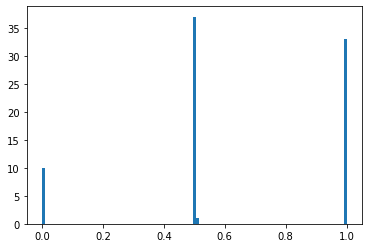

In [12]:
import matplotlib.pyplot as plt

config = 'ent'
function_val = tori_detector_pytorch(g.get_decision_boundary()).detach().cpu().numpy()[:,0]

hist, _, _ =plt.hist(function_val, bins=101)
plt.show()